# MPS using the deesse wrapper 

The documentation of GEONE is on https://geone.readthedocs.io.

The GitHub of GEONE is on https://github.com/randlab/geone
    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# import package 'geone'
import geone as gn
import pandas as pd

# Data and result paths

In [2]:
# Path of training image
data_dir = '3_5_0_MPS_Training_images/'
TI_name='Uncond_Channel_TI_DS.txt'

# Path of saving the simulation results
saved_sim_dir='Saved_sim_dir/Direct_sampling/'



# Simulation setup

In [ ]:
nreal=100 # Number of realizations

# Setting the Parameters in DS for different combinations
nneighboringNode_list=[5,10,15,20]
distanceThreshold_list=[0.001,0.01,0.1,0.5]
maxScanFraction_list=[1]

# Load training image

In [28]:
filename = os.path.join(data_dir, TI_name)
ti = gn.img.readImageTxt(filename)


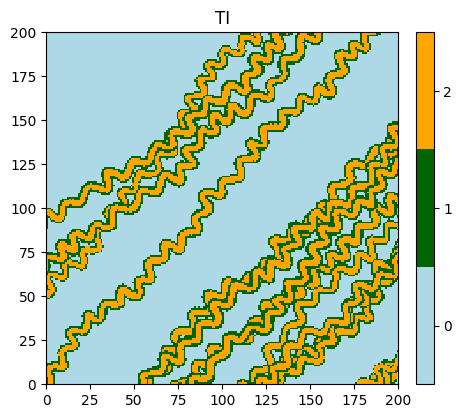

In [29]:
# Setting for categories / colors
categ_val = [0, 1, 2] 
categ_col = ['lightblue', 'darkgreen', 'orange']

plt.figure(figsize=(5,5))
gn.imgplot.drawImage2D(ti, categ=True, categVal=categ_val, categCol=categ_col, title='TI')
plt.show()

In [30]:
ti

*** Img object ***
name = '../../../Saved_dataset_deesse/v4/Unc_Flu_TI_processed.txt'
(nx, ny, nz) = (200, 200, 1) # number of cells along each axis
(sx, sy, sz) = (1.0, 1.0, 1.0) # cell size (spacing) along each axis
(ox, oy, oz) = (0.0, 0.0, 0.0) # origin (coordinates of bottom-lower-left corner)
nv = 1  # number of variable(s)
varname = ['code']
val: (1, 1, 200, 200)-array
*****

In [31]:
ti.val

array([[[[1., 2., 2., ..., 1., 0., 0.],
         [1., 2., 2., ..., 1., 1., 0.],
         [1., 2., 2., ..., 2., 1., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]])

### Simulation grid
Define the simulation grid (number of cells in each direction, cell unit, origin).

In [32]:
nx, ny, nz = 64, 64, 1         # number of cells
sx, sy, sz = ti.sx, ti.sy, ti.sz # cell unit
ox, oy, oz = 0.0, 0.0, 0.0       # origin (corner of the "first" grid cell)

### Define the classes of values
First, the classes of values for which the proportions will be specified have to be defined.

A class is defined as an interval or a union of intervals:
- `cl = [a, b]`, with `a < b`, define the class `cl` of any numerical value $v$ such that $a\leqslant v < b$ ($a$ is included and $b$ excluded);
- `cl = [[a1, b1], [a2, b2]]`, with `a1 < b1`, `a2 < b2` , define the class `cl` of any numerical value $v$ such that $a1\leqslant v < b1$ or $a2\leqslant v < b2$; more than two sub-intervals can be given.

In categorical case, a class for a category has to be defined as an interval of lower bound $a$ (included) and upper bound $b$ (excluded) that contains the value $v$ used for the category. Adapting the bounds allows to exclude other categories.

A class can be defined as a union of intervals to gather several categories whose the category values are not "adjacent".

In [33]:
nclass = 3
class1 = [-0.5, 0.5] # interval [-0.5, 0.5[ (for facies code 0)
class2 = [ 0.5, 1.5] # interval [ 0.5, 1.5[ (for facies code 1)
class3 = [ 1.5, 2.5] # interval [ 1.5, 2.5[ (for facies code 2)

list_of_classes = [class1, class2, class3]

# Unconditional Simulation

In [34]:
run_time=[] # save the run time for each job
parameter_name=[] # Combination of different parameters


process_index=0
total_n_jobs=len(nneighboringNode_list)*len(distanceThreshold_list)*len(maxScanFraction_list) # Total number of jobs (parameter combinations)

for nneighboringNode in nneighboringNode_list:
    for distanceThreshold in distanceThreshold_list:
        for maxScanFraction in maxScanFraction_list:
            # Run deesse
            start_time = time.time() # start time

            
            process_index=process_index+1
            print('Current jobs: %d/%d'%(process_index,total_n_jobs))

            
            deesse_input = gn.deesseinterface.DeesseInput(
                nx=nx, ny=ny, nz=nz,
                sx=sx, sy=sy, sz=sz,
                ox=ox, oy=oy, oz=oz,
                nv=1, varname='code',
                TI=ti,
                distanceType='categorical',
                nneighboringNode=nneighboringNode,
                distanceThreshold=distanceThreshold,
                maxScanFraction=maxScanFraction,
                npostProcessingPathMax=1,
                nrealization=nreal)
            
            # Run simulation
            deesse_output = gn.deesseinterface.deesseRun(deesse_input)

            # Retrieve the realization
            sim = deesse_output['sim']

            # Save simulations in the corresponding folders. The folder name is the combination of paramters
            save_sim=np.zeros((nreal,64,64))
            new_folder='n_%d_t_%.3f_f_%.2f'%(nneighboringNode,distanceThreshold,maxScanFraction)
            new_folder_path=saved_sim_dir+new_folder
            os.makedirs(new_folder_path)
            for i in range(nreal):
                save_sim[i]=np.flip(sim[i].val[0][0],axis=0)
                plt.imsave(new_folder_path+'/'+'%d.png'%i,save_sim[i],cmap='viridis')

            np.save(new_folder_path+'/'+'all_sim_results.npy',save_sim)
            
            # Calculate the runtime
            end_time = time.time()
            elapsed_time = end_time - start_time
            print("Elapsed time:", elapsed_time, "seconds")        
            run_time.append(elapsed_time)
            parameter_name.append(new_folder)

# Save the runtimes of each paramter combination into a csv file
parameters_time={'parameters':parameter_name,'Runtime (s)':run_time}
parameters_time=pd.DataFrame(parameters_time)
parameters_time.to_csv(saved_sim_dir+'parameters_runtime.csv', index=False)    


Current jobs: 1/16
deesseRun: DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 15 thread(s)]
deesseRun: DeeSse run complete
Elapsed time: 1.1595330238342285 seconds
Current jobs: 2/16
deesseRun: DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 15 thread(s)]
deesseRun: DeeSse run complete
Elapsed time: 1.212632656097412 seconds
Current jobs: 3/16
deesseRun: DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 15 thread(s)]
deesseRun: DeeSse run complete
Elapsed time: 1.1701123714447021 seconds
Current jobs: 4/16
deesseRun: DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 15 thread(s)]
deesseRun: DeeSse run complete
Elapsed time: 1.1738903522491455 seconds
Current jobs: 5/16
deesseRun: DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 15 thread(s)]
deesseRun: DeeSse run complete
Elapsed time: 5.492486000061035 seconds
Current jobs: 6/16
deesseRun: DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 15 threa